# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [26]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [45]:
# YOUR CODE HERE
from common_utils import (
    MLP,
    CustomDataset,
    preprocess_dataset,
    intialise_loaders,
    split_dataset,
    preprocess_dataset,
)
loss_fn = nn.BCELoss()

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [40]:
from collections import defaultdict

def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    kf = KFold(n_splits=5)

    for batch_size in parameters:
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
            X_train_subset = X_train[train_index]
            y_train_subset = y_train[train_index]
            X_val_subset = X_train[test_index]
            y_val_subset = y_train[test_index]

            X_train_scaled, X_val_scaled = preprocess_dataset(X_train_subset, X_val_subset)

            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(y_train_subset)
            y_val_dict[batch_size].append(y_val_subset)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

batch_sizes = [128, 256, 512, 1024]
X_train, y_train, X_test, y_test = split_dataset(df, ['label','filename'], 0.3, 0)
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [46]:
## For consistencies sake, set num_epochs to 20 for all remaining runs

# YOUR CODE HERE

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.reshape(-1, 1))
        optimizer.zero_grad() # initialize gradient calculations
        loss.backward() # compute gradients
        optimizer.step() # execute one step of GD

        train_loss += loss.item()
        train_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))

    train_loss /= size
    train_acc /= size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.reshape(-1, 1)).item()
            test_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))
    model.train()
    test_loss /= size
    test_acc /= size
    return test_loss, test_acc

def evaluate_fold(train_dataloader, test_dataloader, num_epochs, model, loss_fn, optimizer):
    train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []

    for epoch in tqdm.tqdm(range(num_epochs)):

        start = time.time()

        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)

        end = time.time()

        test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
        train_loss_.append(train_loss), train_acc_.append(train_acc)
        test_loss_.append(test_loss), test_acc_.append(test_acc)

    last_epoch_time = end-start

    return train_loss_, train_acc_, test_loss_, test_acc_, last_epoch_time

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes):

    cross_validation_accuracies = {}
    cross_validation_val_accuracies, cross_validation_train_accuracies, cross_validation_times = defaultdict(list), defaultdict(list), defaultdict(list)

    for batch_size in batch_sizes:
        cur_batch_X_train_folds = X_train_scaled_dict[batch_size]
        cur_batch_y_train_folds = y_train_dict[batch_size]
        cur_batch_X_val_folds = X_val_scaled_dict[batch_size]
        cur_batch_y_val_folds = y_val_dict[batch_size]

        folds = zip(cur_batch_X_train_folds, cur_batch_y_train_folds, cur_batch_X_val_folds, cur_batch_y_val_folds)

        for X_train, y_train, X_val, y_val in folds:

            ## Refresh the model for each fold
            num_epochs = 20
            lr = 0.001
            no_features = 77
            no_hidden = 3
            no_labels = 1
            model = MLP(no_features, no_hidden, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)
            loss_fn = nn.BCELoss()

            eval_params = {
                'num_epochs': num_epochs,
                'model': model,
                'loss_fn': loss_fn,
                'optimizer': optimizer,
            }


            train_dataloader, val_dataloader = intialise_loaders(X_train, y_train, X_val, y_val, batch_size = batch_size)
            train_loss_, train_acc_, val_loss_, val_acc_, last_epoch_time = evaluate_fold(train_dataloader, val_dataloader, **eval_params)

            cross_validation_train_accuracies[batch_size].append(train_acc_)
            cross_validation_val_accuracies[batch_size].append(val_acc_)
            cross_validation_times[batch_size].append(last_epoch_time)

    cross_validation_accuracies['train'] = cross_validation_train_accuracies
    cross_validation_accuracies['val'] = cross_validation_val_accuracies
    return cross_validation_accuracies, cross_validation_times



cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes)


100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

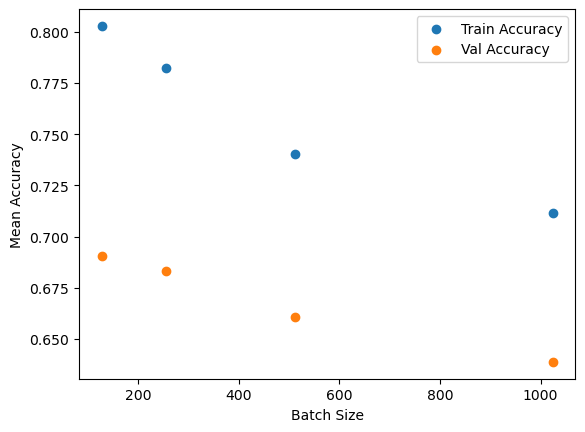

In [47]:
# YOUR CODE HERE

def process_accuracies(accuracy_dict):
    cv_accuracies_df = pd.DataFrame(accuracy_dict).transpose()
    cv_accuracies_df.index = cv_accuracies_df.index.set_names(["batch_size"])
    cv_accuracies_df.columns = [f"Fold_{i}" for i in cv_accuracies_df.columns]
    cv_accuracies_df = cv_accuracies_df.explode(list(cv_accuracies_df.columns))
    cv_accuracies_df['mean_acc'] = cv_accuracies_df.mean(axis=1)
    return cv_accuracies_df

mean_train_acc = process_accuracies(cross_validation_accuracies['train'])
mean_val_acc = process_accuracies(cross_validation_accuracies['val'])
mean_train_acc['epoch'] = list(range(1,21))*4
mean_val_acc['epoch'] = list(range(1,21))*4

final_epoch_train_acc = mean_train_acc.loc[mean_train_acc['epoch']==20][['mean_acc']]
final_epoch_val_acc = mean_val_acc.loc[mean_val_acc['epoch']==20][['mean_acc']]

plt.scatter(final_epoch_train_acc.index, final_epoch_train_acc.values, label = "Train Accuracy")
plt.scatter(final_epoch_val_acc.index, final_epoch_val_acc.values, label = "Val Accuracy")
plt.ylabel("Mean Accuracy")
plt.xlabel("Batch Size")
plt.legend()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [48]:
# df = pd.DataFrame({'Batch Size': [],
#                    'Last Epoch Time': [],
#                   })

# df


def process_times(time_dict):
    cv_times_df = pd.DataFrame(time_dict).transpose()
    cv_times_df.index = cv_times_df.index.set_names(["batch_size"])
    cv_times_df.columns = [f"Fold_{i}" for i in cv_times_df.columns]
    cv_times_df = cv_times_df.explode(list(cv_times_df.columns))
    cv_times_df['mean_time'] = cv_times_df.mean(axis=1)
    return cv_times_df

mean_train_times = process_times(cross_validation_times)
mean_train_times

,Fold_0,Fold_1,Fold_2,Fold_3,Fold_4,mean_time
batch_size,,,,,,
128,0.222024,0.223181,0.221285,0.267319,0.202613,0.227284
256,0.158495,0.280703,0.153059,0.180104,0.172450,0.188962
512,0.126865,0.136337,0.117966,0.128126,0.162478,0.134354
1024,0.097492,0.104920,0.112122,0.097099,0.104533,0.103233


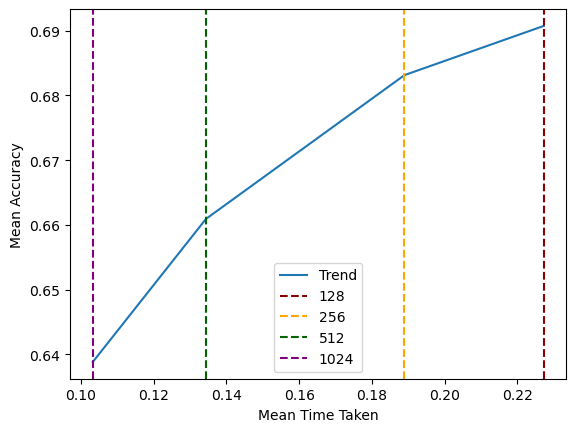

In [49]:
# YOUR CODE HERE
import seaborn as sns
## Logic - maximize validation accuracy while minimizing training time

acc_and_times_df = pd.merge(mean_train_times[['mean_time']], final_epoch_val_acc, on = 'batch_size')

sns.lineplot(x = acc_and_times_df['mean_time'], y = acc_and_times_df['mean_acc'].to_list(), label = "Trend")
for size, cmap in zip(batch_sizes, ['darkred', 'orange', 'darkgreen', 'purple']):
    x_pos = acc_and_times_df['mean_time'].loc[size]
    plt.axvline(x_pos, color = cmap, linestyle="--", label = size)
plt.ylabel("Mean Accuracy")
plt.xlabel("Mean Time Taken")
plt.legend()
plt.show()

optimal_batch_size = 128
reason = """
From the plot, we can see that in general, as the batch size increases, both the accuracy and the time taken for training decreases.
To select an optimal batch size would depend on the user's requirements.
For example, if the user has limited computational resources and values faster training time over accuracy, they may prefer a larger batch size such as 1024 (in purple)
On the other hand, if the user prefers performance and has resources to spare, they may favour a smaller batch size such as 128 (in red)
As the dataset is not too extensive and computational resources are not an issue at this point, I would favour a model with better performance.
Thus, I would choose a smaller batch size of 128

Other ways of selecting the batch size would be to weigh the accuracy against time taken such as using ratios, which is more balanced
Another way could be to inspect plots like the one below, and choosing the batch size where the gradient of the curve starts to flatten out
That would indicate that the marginal increase in accuracy no longer justifies the increase in time taken.
"""